# Training the model

## 1. Import the Packages

In [4]:
#import the packages
import statsapi
import csv 
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from apitester import extract_pitch_sequences
from apitester import get_historical_mlb_games


## 2. Create a pitch map which combines simular pitches from the statcast classification for a more cohesive model 


In [5]:
pitch_map = {
    'FF': 'Fastball', 
    'FA': 'Fastball', 
    'FS': 'Fastball', 
    'SI': 'Fastball',
    'FC': 'Fastball',
    'CH': 'Changeup', 
    'CS': 'Changeup',
    'SL': 'Slider',
    'SV': 'Slider', 
    'ST': 'Slider',
    'CU': 'Curve', 
    'KC': 'Curve' ,
    'KN': 'Knuckleball',  
    'EP': 'Eephus'
}


## 3. Grab the pitches for 500 games last year in the 2024 MLB season
- Clean the data
    - Remove null values 
    - Remove rare pitches such as Forkballs, Screwballs and Knuckleballs which add noise to the model 

In [6]:
historical_games = get_historical_mlb_games(500)
historical_game_pitches = []
drop_cols = [
    'pitch_description', 'pitch_call', 'pitch_result',
    'strike_zone_x', 'strike_zone_z',
    'batter_name', 'pitcher_name',
    'home_team', 'away_team',
    'pitch_count', 'velocity', 'spin_rate'
]


csv_filename = 'hist_pitch_data'
for game in historical_games:
    game_pk = game['gamePk']
    pitch_data = extract_pitch_sequences(game_pk)
    historical_game_pitches.extend(pitch_data)
pitch_df = pd.DataFrame(historical_game_pitches)
pitch_df = pitch_df.drop(columns = drop_cols )
pitch_df = pitch_df[pitch_df['pitch_type'].notnull()]
pitch_df = pitch_df[~pitch_df['pitch_type'].isin(['FO', 'SC', 'KN'])]
pitch_df['pitch_type'] = pitch_df['pitch_type'].map(pitch_map)
csv_filename = f"all_pitch_data.csv"
#pitch_df.to_csv(csv_filename, index=False)
pitch_df

,outs,inning,half_inning,batter_id,pitcher_id,batter_side,pitcher_hand,runners_on_first,runners_on_second,runners_on_third,balls,strikes,pitch_type,home_score,away_score
0,0,1,top,672761,680573,L,R,0,0,0,0,0,Fastball,0,0
1,0,1,top,672761,680573,L,R,0,0,0,1,0,Fastball,0,0
2,0,1,top,672761,680573,L,R,0,0,0,2,0,Fastball,0,0
3,0,1,top,672761,680573,L,R,0,0,0,2,1,Fastball,0,0
4,0,1,top,672761,680573,L,R,0,0,0,2,2,Changeup,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139270,2,9,top,628451,608032,R,R,0,0,0,0,0,Slider,5,2
139271,2,9,top,628451,608032,R,R,0,0,0,0,1,Fastball,5,2
139272,2,9,top,628451,608032,R,R,0,0,0,1,1,Slider,5,2
139273,2,9,top,628451,608032,R,R,0,0,0,1,2,Fastball,5,2


This is the pitch type distribution from last year 

In [7]:
pitch_counts = pitch_df['pitch_type'].value_counts()
print(pitch_counts)

pitch_type
Fastball    79040
Slider      29558
Changeup    13480
Curve       10927
Eephus        128
Name: count, dtype: int64


## 4. Enocode the data

`encode_categorical_data`: this function encodes the  categorical variables in the data to either label or one hot encoding   

In [8]:
def encode_categorical_data(df, target_column='pitch_type', method='label_encoding'):
    """
    Encode categorical variables in baseball pitch data for Random Forest model
    
    Parameters:
    df: pandas DataFrame with pitch data
    target_column: string, name of target variable column
    method: string, either 'label_encoding' or 'one_hot_encoding'
    
    Returns:
    encoded_df: DataFrame with encoded categorical variables
    encoders: dict of encoders used (for inverse transformation if needed)
    """
    
    # Create a copy to avoid modifying original data
    encoded_df = df.copy()
    encoders = {}
    
    # Identify categorical columns
    categorical_columns = [
        'half_inning',      # 'top' or 'bottom'
        'batter_side',      # 'L', 'R', 'S' (Left, Right, Switch)
        'pitcher_hand',     # 'L', 'R' (Left, Right)
        'pitch_type'        # Various pitch types like 'FF', 'CU', 'SL', etc.
    ]
    
    # Identify ID columns (usually treated as categorical for Random Forest)
    id_columns = [
        'batter_id',
        'pitcher_id'
    ]
    
    if method == 'label_encoding':
        # Label encoding for all categorical variables
        le = LabelEncoder()
        
        for col in categorical_columns:
            if col in encoded_df.columns:
                encoded_df[col] = le.fit_transform(encoded_df[col].astype(str))
                encoders[col] = le
                print(f"Label encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")
        
        # For ID columns, we can use label encoding or treat them as categorical
        # Since Random Forest can handle high cardinality, we'll use label encoding
        for col in id_columns:
            if col in encoded_df.columns:
                le_id = LabelEncoder()
                encoded_df[col] = le_id.fit_transform(encoded_df[col].astype(str))
                encoders[col] = le_id
                print(f"Label encoded {col}: {len(le_id.classes_)} unique values")
    
    elif method == 'one_hot_encoding':
        # One-hot encoding for low cardinality categorical variables
        low_cardinality_cols = ['half_inning', 'batter_side', 'pitcher_hand']
        
        for col in low_cardinality_cols:
            if col in encoded_df.columns:
                # Create dummy variables
                dummies = pd.get_dummies(encoded_df[col], prefix=col)
                encoded_df = pd.concat([encoded_df, dummies], axis=1)
                encoded_df.drop(col, axis=1, inplace=True)
                encoders[col] = list(dummies.columns)
                print(f"One-hot encoded {col}: {list(dummies.columns)}")
        
        # For pitch_type (if it's not the target), use label encoding due to potentially high cardinality
        if 'pitch_type' in encoded_df.columns and 'pitch_type' != target_column:
            le_pitch = LabelEncoder()
            encoded_df['pitch_type'] = le_pitch.fit_transform(encoded_df['pitch_type'].astype(str))
            encoders['pitch_type'] = le_pitch
            print(f"Label encoded pitch_type: {dict(zip(le_pitch.classes_, le_pitch.transform(le_pitch.classes_)))}")
        
        # For ID columns, use label encoding
        for col in id_columns:
            if col in encoded_df.columns:
                le_id = LabelEncoder()
                encoded_df[col] = le_id.fit_transform(encoded_df[col].astype(str))
                encoders[col] = le_id
                print(f"Label encoded {col}: {len(le_id.classes_)} unique values")
    
    return encoded_df, encoders




In [9]:
encoded_df_label, encoders_label = encode_categorical_data(pitch_df,method='one_hot_encoding')
pitch_type_encoder = LabelEncoder()

# encode pitch_type
y = pitch_type_encoder.fit_transform(encoded_df_label['pitch_type'])




pitch_type_mapping = dict(zip(pitch_type_encoder.classes_, pitch_type_encoder.transform(pitch_type_encoder.classes_)))
print("Pitch Type Mapping:", pitch_type_mapping)
X = encoded_df_label.drop(columns=['pitch_type'])
print()

One-hot encoded half_inning: ['half_inning_bottom', 'half_inning_top']
One-hot encoded batter_side: ['batter_side_L', 'batter_side_R']
One-hot encoded pitcher_hand: ['pitcher_hand_L', 'pitcher_hand_R']
Label encoded batter_id: 895 unique values
Label encoded pitcher_id: 836 unique values
Pitch Type Mapping: {'Changeup': np.int64(0), 'Curve': np.int64(1), 'Eephus': np.int64(2), 'Fastball': np.int64(3), 'Slider': np.int64(4)}



## 5. Train the model
for the models I used awfdasdf

### random forest model:
We start by training a Random Forest Classifier, which is an ensemble method based on decision trees. It builds multiple decision trees during training and outputs the class that is the mode of the classes of the individual trees.

This model is generally robust to overfitting, especially with a large number of features, and can handle both categorical and numerical data well.

#### Create the model
We initialize the Random Forest with default hyperparameters or customized values like:

- `n_estimators`: Number of trees in the forest (e.g., 100).
- `max_depth`: Maximum depth of each tree to control overfitting.
- `random_state`: Ensures reproducibility.

The model is trained on the one-hot encoded pitch features and corresponding pitch types as labels.



In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classes:", pitch_type_encoder.classes_)
labels = pitch_type_encoder.transform(pitch_type_encoder.classes_)
print(classification_report(y_test, y_pred, labels=labels, target_names=pitch_type_encoder.classes_))

Accuracy: 0.5621361775641266
Classes: ['Changeup' 'Curve' 'Eephus' 'Fastball' 'Slider']
              precision    recall  f1-score   support

    Changeup       0.30      0.15      0.20      2680
       Curve       0.28      0.12      0.17      2165
      Eephus       0.78      0.58      0.67        24
    Fastball       0.62      0.82      0.71     15891
      Slider       0.37      0.22      0.28      5867

    accuracy                           0.56     26627
   macro avg       0.47      0.38      0.40     26627
weighted avg       0.51      0.56      0.52     26627



#### confustion matrix 


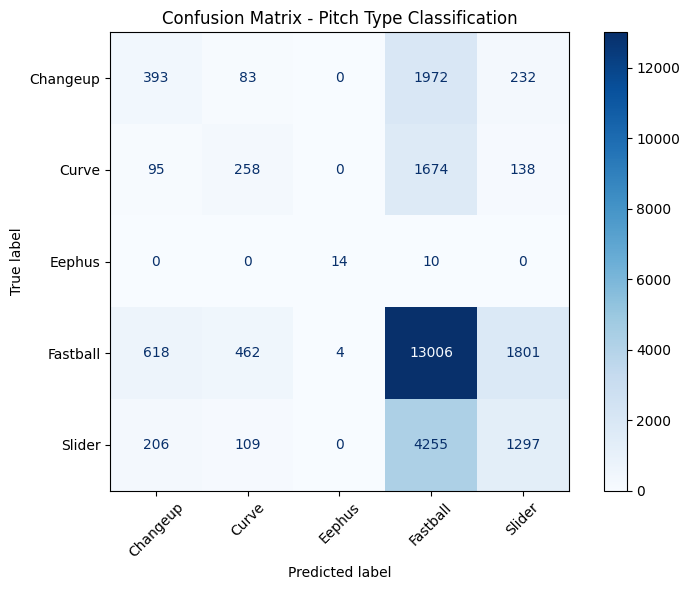

In [11]:
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Display it as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pitch_type_encoder.classes_)
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust size if needed
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Pitch Type Classification")
plt.tight_layout()
plt.show()

### xgboost Model:
Next, we train an `XGBoost Classifier`, a powerful gradient boosting algorithm that often performs better than Random Forests, especially in structured/tabular data.

XGBoost uses decision trees like Random Forest but builds them sequentially, with each new tree correcting the errors of the previous ones. It also incorporates regularization, which helps prevent overfitting.

#### Create the model
We define and train the model with common hyperparameters:

- `n_estimators`: Total number of trees to build.
- `learning_rate`: Controls the contribution of each tree.
- `max_depth`: Limits the depth of individual trees to avoid overfitting.
- `objective`: Defines the learning task, such as `"multi:softmax"` for multiclass classification.

The training is done using the same encoded features and pitch labels.

In [12]:
clf = XGBClassifier(
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='mlogloss',
    scale_pos_weight=None,  # We'll auto-balance later
    random_state=42
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classes:", pitch_type_encoder.classes_)
print(classification_report(y_test, y_pred, labels=labels, target_names=pitch_type_encoder.classes_, zero_division=0))

c:\Users\Malachi Rosario\OneDrive\Desktop\Programing-Projects\PitchPredictionEngine\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:19:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.6008562737071393
Classes: ['Changeup' 'Curve' 'Eephus' 'Fastball' 'Slider']
              precision    recall  f1-score   support

    Changeup       0.46      0.08      0.13      2680
       Curve       0.45      0.04      0.08      2165
      Eephus       0.82      0.75      0.78        24
    Fastball       0.62      0.93      0.74     15891
      Slider       0.46      0.14      0.22      5867

    accuracy                           0.60     26627
   macro avg       0.56      0.39      0.39     26627
weighted avg       0.55      0.60      0.51     26627



#### confustion matrix

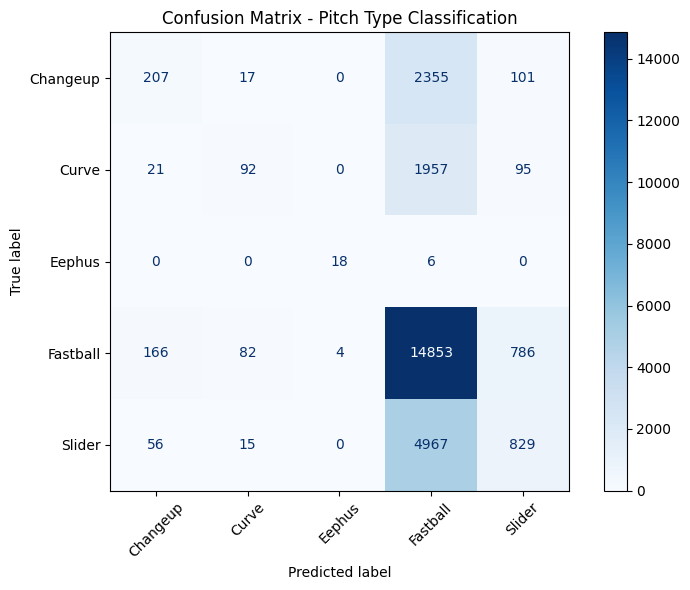

In [13]:
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Display it as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pitch_type_encoder.classes_)
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust size if needed
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Pitch Type Classification")
plt.tight_layout()
plt.show()

## 6. choose a model and export it
After evaluating both the Random Forest and XGBoost models, I decided to move forward with the XGBoost Classifier for deployment.

This decision was based on:

- Higher overall accuracy on the validation set.
- Better class separation in the confusion matrix, particularly for minority classes like Curve and Slider.
- Superior handling of class imbalance, thanks to built-in regularization and boosting.
- XGBoost also offers faster inference and more control over model complexity via parameters like `max_depth`, `learning_rate`, and subsample``.

The model was trained using the cleaned and one-hot encoded dataset, and then serialized using `joblib` for future predictions.

In [14]:
joblib.dump(clf, 'xgb_pitch_model.joblib')
joblib.dump(pitch_type_encoder, 'pitch_label_encoder.joblib') 
joblib.dump(X.columns.tolist(), 'model_features.joblib')

['model_features.joblib']